In [48]:
scope.dis()
target.dis()

In [1]:
# import relevant libraries
import chipwhisperer as cw
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import random
from scipy.stats import multivariate_normal

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\chipwhisperer\capture\trace\TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


In [2]:
# initiate scope and target definitions for chipwhisperer
scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial)
scope.default_setup()

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 2481072                   to 27067943                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 0                         to 29538459                 
scope.clock.adc_rate                     changed from 0.0                       to 29538459.0               
scope.clock.clkgen_

In [3]:
SAMPLES = 3000
scope.adc.samples = SAMPLES  # scope.adc - The Analog to Digital converter on the chipwhisperer
                         # samples = 3000 - The number of ADC samples to record in a single capture

.Add here your docs

In [32]:
%%sh
make PLATFORM=CWLITEARM SOURCE=chipwhisperer_hw2_template.c

No CRYPTO_TARGET passed - defaulting to TINYAES128C
Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (Arm GNU Toolchain 14.2.Rel1 (Build arm-14.52)) 14.2.1 20241119
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir objdir-CWLITEARM 
.
Compiling:
    chipwhisperer_hw2_template.c ...Done!
.
Compiling:
    C:/Users/ADMIN/ChipWhisperer/chipwhisperer/firmware/mcu/simpleserial/simpleserial.c ...Done!
.
Compiling:
    C:/Users/ADMIN/ChipWhisperer/chipwhisperer/firmware/mcu/hal/hal.c ...Done!
.
Compiling:
    C:/Users/ADMIN/ChipWhisperer/chipwhisperer/firmware/mcu/hal//stm32f3/stm32f3_hal.c ...Done!
.
Compiling:
    C:/Users/ADMIN/ChipWhisperer/chipwhispe

C:/Program Files (x86)/Arm GNU Toolchain arm-none-eabi/14.2 rel1/bin/../lib/gcc/arm-none-eabi/14.2.1/../../../../arm-none-eabi/bin/ld.exe: warning: output-CWLITEARM.elf has a LOAD segment with RWX permissions


Memory region         Used Size  Region Size  %age Used
             RAM:        2416 B        40 KB      5.90%
             ROM:        5884 B       256 KB      2.24%
Done!
.
Creating load file for Flash: output-CWLITEARM.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature output-CWLITEARM.elf output-CWLITEARM.hex
.
Creating load file for Flash: output-CWLITEARM.bin
arm-none-eabi-objcopy -O binary -R .eeprom -R .fuse -R .lock -R .signature output-CWLITEARM.elf output-CWLITEARM.bin
.
Creating load file for EEPROM: output-CWLITEARM.eep
arm-none-eabi-objcopy -j .eeprom --set-section-flags=.eeprom="alloc,load" \
--change-section-lma .eeprom=0 --no-change-warnings -O ihex output-CWLITEARM.elf output-CWLITEARM.eep || exit 0
.
Creating Extended Listing: output-CWLITEARM.lss
arm-none-eabi-objdump -h -S -z output-CWLITEARM.elf > output-CWLITEARM.lss
.
Creating Symbol Table: output-CWLITEARM.sym
arm-none-eabi-nm -n output-CWLITEARM.elf > output-CWLITEARM.sym
Size after:

In [4]:
# This function get command and text and comunicate with chipwhisperer that have AES encrypt program on it:
# if command = 'k' : define the AES key as pt.
# if command = 'p' : encrypte pt

def execute_trace(command, pt):
    #uint8_t* pt, uint8_t len
    """
    Executes a trace using the given plaintext at length 16, with the provided scope and target objects.

    Parameters:
        command (str): The command to send to the target.
        pt (bytearray): The plaintext to send to the target.
        scope: The scope object for controlling the capture process.
        target: The target object for sending and receiving data.

    Returns:
        tuple: A tuple containing the capture trace and the response from the target (encrypted plaintext)
    """
    try:
        # Flush target and arm the scope
        target.flush()
        scope.arm()
        
        # Convert pt to bytearray
        #plaintext = bytearray(pt, 'utf-8')

        # Send command and data to target
        target.simpleserial_write(command, pt)
     
        # Capture the trace
        ret = scope.capture()

        if ret:
            print("ERROR: Capture failed.")
            return None, None

        # Retrieve the trace and the target response
        trace = scope.get_last_trace()

        # return None for key init
        if command == 'k':
            return trace, None
        
        #response = target.simpleserial_read('r', 16).decode('utf-8')
        response = target.simpleserial_read('r', 16)

        return trace, response
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None


for byte i in range(16): 

0.  load the template key hex file V
1.  collect traces by running multiple keys and pt (the rest byte are const) V
2.  grouping them by their value Sbox(pt[i]^k[i]) V
3.  group the Sbox groups by their HW value V
4.  calculate SNR by HW groups ((var of mean)/(mean of var)) V
5.  find 5 POIs V
6.  delete the rest samples from the collected traces V
7.  for each Sbox value: V
     a. calculate mean vector (the mean of each POI (5) at this Sbox value) V
     b. calculate covariance matrix (matrix[i][j] = cov(POI[i],POI[j])) V
     c. calculate 𝑓(𝑥)=1/√((2𝜋)^𝑘 |Σ| ) 𝑒^(−((𝑥−𝜇)^𝑇 Σ^(−1) (𝑥−𝜇))/2) for this Sbox value V
8.  load the secret key hex file V
9.  collect traces wite the secret key V
10. for j in range(256): (possible values for byte i)
     a. check each trace's log of probability by f(x) of class Sbox(pt[i]^j) V
     b. compute the total probability of value j (sum of the logs)
11. choose the j with the highest probability
        


In [5]:
# This function load the template hex file (which we can define the key)
def load_template_hex_file():    
    # sending temaplate modified file
    hex = './output-CWLITEARM.hex'
    cw.program_target(scope, cw.programmers.STM32FProgrammer, hex)

In [6]:
# This function load the hex file with the sevcret key in it
def load_secret_key_hex_file():    
    # Sending the hex file with the correct key to the chipwhisperer
    hex = './output-CWLITEARM.hex'
    #hex = './code-with-key-CWLITEARM.hex'
    cw.program_target(scope, cw.programmers.STM32FProgrammer, hex)

In [7]:
# Define AES SBOX
SBOX = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5,
    0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0,
    0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC,
    0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A,
    0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0,
    0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B,
    0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85,
    0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5,
    0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17,
    0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88,
    0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C,
    0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9,
    0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6,
    0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E,
    0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94,
    0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68,
    0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]

### TEMPLATE PHASE

In [51]:
load_template_hex_file()

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5903 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5903 bytes


collect random traces

In [8]:
# the function get: traces_num = int, the num of traces to collect
# the function do: collect traces of random keys and plaintexts encryptions
# the function return: arrays of the random plaintext, keys and their traces. (traces[i] is the trace of encrypt plaintext[i] with keys[i])

def collect_template_traces(traces_num):

    plaintext = []
    keys = []
    traces = []

    # run over trace_num different inputss
    for k in range(traces_num):  
        # randomize key & pt and add them to matches arrays
        rand_key = bytearray((random.getrandbits(128)).to_bytes(16, byteorder = 'big'))        
        rand_pt = bytearray((random.getrandbits(128)).to_bytes(16, byteorder = 'big')) 
        keys.append(rand_key)
        plaintext.append(rand_pt)
        # update key at the chipwhisperer
        execute_trace('k', rand_key)
        # encrypt pt and save the trace
        trace, res = execute_trace('p', rand_pt)
        traces.append(trace)
    return plaintext, keys, traces

In [ ]:
template_plaintext, template_keys, template_traces = collect_template_traces(100000)

In [ ]:
# save the data
np.savez_compressed('multiple_template_traces.npz', template_traces=template_traces, template_keys=template_keys, template_plaintext=template_plaintext)

In [9]:
# load saved data
loaded_data = np.load('multiple_template_traces.npz')
template_traces = loaded_data['template_traces']
template_keys = loaded_data['template_keys']
template_plaintext = loaded_data['template_plaintext']

sort the collected traces by their HW value

In [10]:
# The function get: the attacked byte and data to sort (pt, keys, traces)
# The function return: array which at index i there are all the traces that sustaining HW(SBOX(key ^ pt)) = i
def sort_by_HW(byte_i, template_plaintext, template_keys, template_traces):
    hw_groups = [[] for _ in range(9)] 
    # go over all traces
    for i in range(len(template_traces)):
        # calculate HW and add it to the correct index at the sorted array
        hw_class = bin(SBOX[template_keys[i][byte_i] ^ template_plaintext[i][byte_i]]).count('1')
        hw_groups[hw_class].append(np.array(template_traces[i]))
    return hw_groups

In [34]:
byte_i = 0
traces_by_HW = sort_by_HW(byte_i, template_plaintext, template_keys, template_traces)

find POIs

In [ ]:
# This function get traces sorted by classes and compute their SNR
def compute_snr_from_hw_groups(traces_by_classes):    
    """
    Compute SNR at each point across all classes.
    traces_by_classes: list of 9 lists, each with traces of a specific HW class.
    """

    mean_group = []
    var_group = []
    # compute the var & mean of any HW class
    for i, group in enumerate(traces_by_classes):
        group = np.array(group)
        
        # skip empty or malformed groups
        if group.shape[0] == 0 or np.isnan(group).any() or np.isinf(group).any():
            print(f"Skipping HW class {i} in SNR computation: empty or invalid")
            continue
        
        mean_group.append(np.mean(group, axis=0))
        var_group.append(np.var(group, axis=0))

    if len(var_group) == 0 or len(mean_group) == 0:
        raise ValueError("No valid HW classes available for SNR computation.")

    # compute mean of vars and var of means (of all claesses)
    mean_of_var = np.mean(var_group, axis=0)
    var_of_mean = np.var(mean_group, axis=0)
    snr = var_of_mean / (mean_of_var + 1e-5)  # avoid division by zero
    return(snr)

In [13]:
# This function get: computed SNR (array), number of POIs to find, minimum gap between POIs
# This function: find the top num_pois POIs and return them
def find_POIs(snr_array, num_pois=5, min_gap=2):
    snr = np.array(snr_array)
    selected = []
    snr_copy = snr.copy()

    # while there are no num_pois POIs yet- find the next POI
    while len(selected) < num_pois:
        # find the POI (with max value)
        max_idx = np.argmax(snr_copy)
        selected.append(max_idx)

        # minimaize all the area at distance 10 or less (to avoid choosing those indexes as POIs)
        left = max(0, max_idx - min_gap)
        right = min(len(snr_copy), max_idx + min_gap)
        snr_copy[left:right] = -1 

    return sorted(selected)


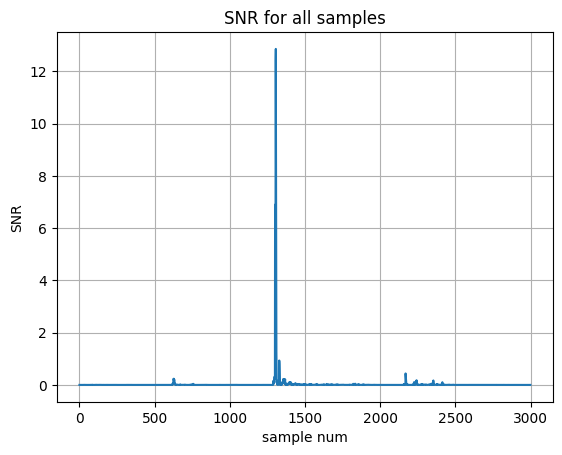

[1302, 1306, 1308, 1310, 1329]


In [35]:
# print SNR and POIs
SNR = compute_snr_from_hw_groups(traces_by_HW)
plt.plot(range(len(SNR)), SNR)
plt.xlabel("sample num")
plt.ylabel("SNR")
plt.title("SNR for all samples")
plt.grid()
plt.show()
POIs = find_POIs(SNR)
print(POIs)

filter only the POIs values from the collected traces

In [15]:
# This function get sorted traces (by HW) and POIs
# and return those trace only with the POIs values
def filter_POIs(traces_by_classes, POIs):
    traces_at_POIs = [[] for _ in range(9)]
    # go over all HW clases (the index of the class and the class itself- the traces)
    for c_index, c in enumerate(traces_by_classes):
        # go over all traces
        for trace in c:
            # take only the POIs from the trace
            t = [trace[p] for p in POIs]
            traces_at_POIs[c_index].append(t)
    return traces_at_POIs   

In [36]:
traces_at_POIs = filter_POIs(traces_by_HW, POIs)

calculate PDFs of all classes

In [17]:
# This function get: list of traces (with POIs values only, 5 POIs)
# This function return: PDF function of the traces distribution
def calculate_PDF(traces_at_POIs_list):
    # calculate mean vector
    mean_traces = np.mean(traces_at_POIs_list, axis=0)
    # calculate cov matrix
    traces_by_POIs = [[] for _ in range(5)]
    for i in range(5):
        traces_by_POIs[i] = [traces_at_POIs_list[j][i] for j in range(len(traces_at_POIs_list))]
    cov_matrix = np.cov(traces_by_POIs)
    
    # adding EPS to avoid singularity
    EPS = 1e-6
    cov_matrix += np.eye(cov_matrix.shape[0]) * EPS

    # calculate and return PDF function
    PDF_func = multivariate_normal(mean=mean_traces, cov=cov_matrix)
    return PDF_func


In [37]:
# calculate PDF for all classes
SBOX_PDFs = [0] * 9
for i in range(9):
    SBOX_PDFs[i] = calculate_PDF(traces_at_POIs[i])

### ATTACK PHASE

collect traces of the secret key


In [58]:
%%sh
make PLATFORM=CWLITEARM SOURCE=simpleserial-aes-with-key.c

No CRYPTO_TARGET passed - defaulting to TINYAES128C
Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (Arm GNU Toolchain 14.2.Rel1 (Build arm-14.52)) 14.2.1 20241119
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir objdir-CWLITEARM 
.
Compiling:
    simpleserial-aes-with-key.c ...Done!
.
Compiling:
    C:/Users/ADMIN/ChipWhisperer/chipwhisperer/firmware/mcu/simpleserial/simpleserial.c ...Done!
.
Compiling:
    C:/Users/ADMIN/ChipWhisperer/chipwhisperer/firmware/mcu/hal/hal.c ...Done!
.
Compiling:
    C:/Users/ADMIN/ChipWhisperer/chipwhisperer/firmware/mcu/hal//stm32f3/stm32f3_hal.c ...Done!
.
Compiling:
    C:/Users/ADMIN/ChipWhisperer/chipwhisper

C:/Program Files (x86)/Arm GNU Toolchain arm-none-eabi/14.2 rel1/bin/../lib/gcc/arm-none-eabi/14.2.1/../../../../arm-none-eabi/bin/ld.exe: warning: output-CWLITEARM.elf has a LOAD segment with RWX permissions


Memory region         Used Size  Region Size  %age Used
             RAM:        2416 B        40 KB      5.90%
             ROM:        5904 B       256 KB      2.25%
Done!
.
Creating load file for Flash: output-CWLITEARM.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature output-CWLITEARM.elf output-CWLITEARM.hex
.
Creating load file for Flash: output-CWLITEARM.bin
arm-none-eabi-objcopy -O binary -R .eeprom -R .fuse -R .lock -R .signature output-CWLITEARM.elf output-CWLITEARM.bin
.
Creating load file for EEPROM: output-CWLITEARM.eep
arm-none-eabi-objcopy -j .eeprom --set-section-flags=.eeprom="alloc,load" \
--change-section-lma .eeprom=0 --no-change-warnings -O ihex output-CWLITEARM.elf output-CWLITEARM.eep || exit 0
.
Creating Extended Listing: output-CWLITEARM.lss
arm-none-eabi-objdump -h -S -z output-CWLITEARM.elf > output-CWLITEARM.lss
.
Creating Symbol Table: output-CWLITEARM.sym
arm-none-eabi-nm -n output-CWLITEARM.elf > output-CWLITEARM.sym
Size after:

In [42]:
# load the secret key hex file
load_secret_key_hex_file()

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5903 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5903 bytes


In [20]:
# this function collect traces of random inputs encryption with the secret key. 
# the function return the traces and the coresponding plaintexts
def collect_secret_key_traces(traces_num):
    plaintext = []
    traces = [] 
    for k in range(traces_num):  
        # randomize plaintext
        rand_pt = bytearray((random.getrandbits(128)).to_bytes(16, byteorder = 'big')) 
        plaintext.append(rand_pt)
        # encrypt pt 
        trace, res = execute_trace('p', rand_pt)
        traces.append(trace)
    return plaintext, traces

In [43]:
secret_plaintext, secret_key_traces = collect_secret_key_traces(2000)

In [44]:
# save the data
np.savez_compressed('multiple_attack_traces.npz', secret_key_traces=secret_key_traces, secret_plaintext=secret_plaintext)

In [ ]:
# load saved data
loaded_data = np.load('multiple_attack_traces.npz')
secret_key_traces = loaded_data['secret_key_traces']
secret_plaintext = loaded_data['secret_plaintext']

In [45]:
filterred_secret_key_traces = [[secret_key_traces[j][POIs[i]] for i in range(5)] for j in range(len(secret_key_traces))]

go over all options and find the correct value

In [ ]:
# This function get traces & plaitexts of secret ket, the attacked byte, the gusses key and all PDFs
# it calculate the log probability of the traces (for the given plaintexts), given the hipothetical key
def find_key_probability(filterred_secret_key_traces, plaintext, byte_i, hypothetical_key, SBOX_PDFs):
    log_probability = 0
    # go over all traces & plaintexts
    for pt_index, pt in enumerate(plaintext):
        # compute HW class
        kp_class = bin(SBOX[hypothetical_key[byte_i] ^ pt[byte_i]]).count('1')
        # compute log probability using the PDF of calculated class
        if SBOX_PDFs[kp_class] is None:
            continue  # Skip this trace if no valid PDF for this HW class
        else:
            probability = SBOX_PDFs[kp_class].logpdf(np.array(filterred_secret_key_traces[pt_index]))
        # sum all log probabilities
        log_probability += probability   
    return log_probability

In [39]:
# go over all possible options and compute log probability of each
key_byte_probaility = [0] * 256
key = bytearray(16)
for i in range(256):
    key[0] = i
    key_byte_probaility[i] = find_key_probability(filterred_secret_key_traces, secret_plaintext, byte_i, key, SBOX_PDFs)

In [47]:
# find the best guess
guessed_byte = np.argmax(key_byte_probaility)

print("Best guess for key[0]:", guessed_byte)
print(key_byte_probaility)

Best guess for key[0]: 84
[19553.40517732497, 19495.04510462861, 19766.606683842416, 19013.79263299282, 19444.328417529032, 19108.685580912308, 19824.55557683068, 18878.63287912029, 19669.513275749614, 19178.46865052844, 19281.177158201604, 19530.676717379716, 19940.99586350584, 18590.389747313402, 19570.974388338556, 19248.64378628717, 19836.77492145823, 19135.2781292083, 19476.31595736319, 18759.551929237514, 19677.526803110013, 19176.6091919652, 19810.61975660157, 19407.29671350668, 18944.09198584669, 18416.130543857325, 19503.41922981361, 18994.46307048309, 19782.429518250905, 18652.210620651767, 18812.20644501689, 19117.72292048713, 19134.198966842938, 19876.423457503388, 19647.082845869365, 19492.33995966866, 20033.963648112607, 19418.79561141407, 19265.78734109706, 19556.23019479546, 19107.691127754097, 19135.0425521503, 19078.890415780636, 19318.024750189023, 19736.0405159269, 19072.954569872483, 19756.911369485508, 19771.627383986448, 19831.297028883535, 19353.19590969496, 199

This was only the attack of byte 0.

Now we will attack all other bytes:

In [ ]:
KEY = bytearray(16)      # zeroing 16 bytes
KEY[0] = guessed_byte    # we already found byte 0

# go over all other key bytes (attack each)
for byte_i in range(1, 16):
    print(f"\nStart attack on byte {byte_i}")
    # ---------------- TEMPLATE PHASE ----------------

    # sort template traces by HW at byte i
    traces_by_HW = sort_by_HW(byte_i, template_plaintext, template_keys, template_traces)

    # find byte i POIs
    SNR = compute_snr_from_hw_groups(traces_by_HW) # calculate SNR
    POIs = find_POIs(SNR) # find POIs
    print(f"Selected POIs for byte {byte_i}: {POIs}")

    # filter only the POIs values from the template traces
    traces_at_POIs = filter_POIs(traces_by_HW, POIs)

    # calculate PDF for all classes
    SBOX_PDFs = [calculate_PDF(traces_at_POIs[i]) for i in range(9)]

    # ---------------- ATTACK PHASE ----------------

    # filter only the POIs values from the secret key traces
    filterred_secret_key_traces = [[secret_key_traces[j][POIs[i]] for i in range(5)] for j in range(len(secret_key_traces))]

    # go over all possible options of byte i and compute log probability of each
    key_byte_probability = [0.0] * 256
    for guess in range(256):
        test_key = bytearray(KEY) # save all known bytes
        test_key[byte_i] = guess  # change byte_i to guess 
        prob = find_key_probability(filterred_secret_key_traces, secret_plaintext, byte_i, test_key, SBOX_PDFs)
        key_byte_probability[guess] = prob

    # find the best guess
    guessed_byte = int(np.argmax(key_byte_probability))
    KEY[byte_i] = guessed_byte

    print(f"Guessed byte {byte_i}: {guessed_byte} (0x{guessed_byte:02x})")
    print(f"Partial key so far: {KEY.hex()}")



Start attack on byte 1
Selected POIs for byte 1: [1478, 1482, 1485, 2066, 2069]
Guessed byte 1: 104 (0x68)
Partial key so far: 54680000000000000000000000000000

Start attack on byte 2
Selected POIs for byte 2: [1654, 1658, 1661, 2082, 2084]
Guessed byte 2: 105 (0x69)
Partial key so far: 54686900000000000000000000000000

Start attack on byte 3
Selected POIs for byte 3: [1830, 1834, 1837, 2130, 2433]
Guessed byte 3: 115 (0x73)
Partial key so far: 54686973000000000000000000000000

Start attack on byte 4
Selected POIs for byte 4: [1342, 1346, 1348, 1350, 2154]
Guessed byte 4: 32 (0x20)
Partial key so far: 54686973200000000000000000000000

Start attack on byte 5
Selected POIs for byte 5: [1518, 1522, 1524, 2041, 2043]
Guessed byte 5: 105 (0x69)
Partial key so far: 54686973206900000000000000000000

Start attack on byte 6
Selected POIs for byte 6: [1694, 1698, 1700, 2097, 2101]
Guessed byte 6: 115 (0x73)
Partial key so far: 54686973206973000000000000000000

Start attack on byte 7
Selected PO

In all graphs, X-axis corresponds to the number of template traces used for building the PDFs,

while a fixed number of attack traces (500) were used for the actual attack phase.

In [49]:
def compare_keys(guessed_key: bytes, real_key: bytes):

    #Compare the guessed AES key with the real key and print results byte by byte.

    correct_count = 0
    for i in range(16):
        real_byte = real_key[i]
        guessed_byte = guessed_key[i]
        if real_byte == guessed_byte:
            correct_count += 1

    accuracy = correct_count / 16
    print("\nSummary:")
    print(f"Correct bytes: {correct_count}/16")
    print(f"Accuracy: {accuracy:.2%}")


In [52]:
real_key = "This is Correct!".encode('ascii')
guessed_key = KEY

compare_keys(guessed_key, real_key)


Summary:
Correct bytes: 16/16
Accuracy: 100.00%


The key we found mach to the real key!

Effect of Attack Trace Count on Key Recovery

In this test, we fixed the number of template traces at 100 and varied the number of attack traces (1–100). The goal was to evaluate how many traces are needed during the attack phase to recover the correct AES key. As more attack traces are used, the key recovery becomes more accurate, since the decision is based on stronger statistical evidence.

In [82]:
# Number of key bytes to attack (full AES key)
BYTES_TO_ATTACK = 16

# Fixed number of template traces to use for training
TEMPLATE_TRACE_COUNT = 100

# Varying number of attack traces to test success
attack_trace_counts = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracies = []

# Loop over different numbers of attack traces
for N in attack_trace_counts:
    print(f"Running attack using {N} attack traces (template fixed at {TEMPLATE_TRACE_COUNT})...")

    # Prepare template data (fixed)
    template_traces_subset = template_traces[:TEMPLATE_TRACE_COUNT]
    template_plaintext_subset = template_plaintext[:TEMPLATE_TRACE_COUNT]
    template_keys_subset = template_keys[:TEMPLATE_TRACE_COUNT]

    # Use first N attack traces
    attack_traces_subset = secret_key_traces[:N]
    attack_plaintext_subset = secret_plaintext[:N]

    # Initialize recovered key
    Initialize_guessed_key = bytearray(16)

    # Attack all 16 bytes
    for byte_i in range(BYTES_TO_ATTACK):
        # TEMPLATE PHASE
        traces_by_HW = sort_by_HW(byte_i, template_plaintext_subset, template_keys_subset, template_traces_subset)
        SNR = compute_snr_from_hw_groups(traces_by_HW)
        POIs = find_POIs(SNR)  # You can also use a fixed POI if needed

        traces_at_POIs = filter_POIs(traces_by_HW, POIs)

        # Create a PDF for each HW class (with error handling)
        SBOX_PDFs = []
        for i in range(9):
            try:
                traces_i = traces_at_POIs[i]
                traces_array = np.array(traces_i)
                if traces_array.shape[0] == 0:
                    raise ValueError("Empty trace group")
                if np.isnan(traces_array).any() or np.isinf(traces_array).any():
                    raise ValueError("NaN or Inf in data")
                pdf = calculate_PDF(traces_i)
            except Exception as e:
                print(f"Skipping HW={i}: {e}")
                pdf = None
            SBOX_PDFs.append(pdf)

        # ATTACK PHASE
        filtered_attack_traces_subset = [
            [trace[i] for i in POIs] for trace in attack_traces_subset
        ]

        key_byte_probability = [0.0] * 256
        for guess in range(256):
            test_key = bytearray(Initialize_guessed_key)
            test_key[byte_i] = guess
            prob = find_key_probability(filtered_attack_traces_subset, attack_plaintext_subset, byte_i, test_key, SBOX_PDFs)
            key_byte_probability[guess] = prob

        guessed_byte = int(np.argmax(key_byte_probability))
        Initialize_guessed_key[byte_i] = guessed_byte

    # Compare recovered key to real key
    real_key = "This is Correct!".encode("ascii")
    correct = sum(Initialize_guessed_key[i] == real_key[i] for i in range(BYTES_TO_ATTACK))
    accuracy = correct / BYTES_TO_ATTACK
    print(f"Key recovery accuracy using {N} attack traces: {accuracy:.2%}\n")

    # Save result
    accuracies.append(accuracy)

Running attack using 1 attack traces (template fixed at 100)...
Skipping HW=0: array must not contain infs or NaNs
Skipping HW=7: array must not contain infs or NaNs
Skipping HW=8: array must not contain infs or NaNs
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group
Skipping HW=8: array must not contain infs or NaNs
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group
Skipping HW=1: array must not contain infs or NaNs
Skipping HW=8: array must not contain infs or NaNs
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group
Skipping HW=8: array must not contain infs or NaNs
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group
Skipping HW=8: Empty trace group
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10072\389987549.py:10: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(traces_by_POIs)


Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group
Skipping HW=8: Empty trace group
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group
Skipping HW=8: Empty trace group
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group
Skipping HW=8: array must not contain infs or NaNs
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW=0: array must not contain infs or NaNs
Skipping HW=8: Empty trace group
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW=0: Empty trace group
Skipping HW=1: array must not contain infs or NaNs
Skipping HW=7: array must not contain infs or NaNs
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW=0: array must not contain infs or NaNs
Skipping HW=1: array must not contain infs or NaNs
Skippin

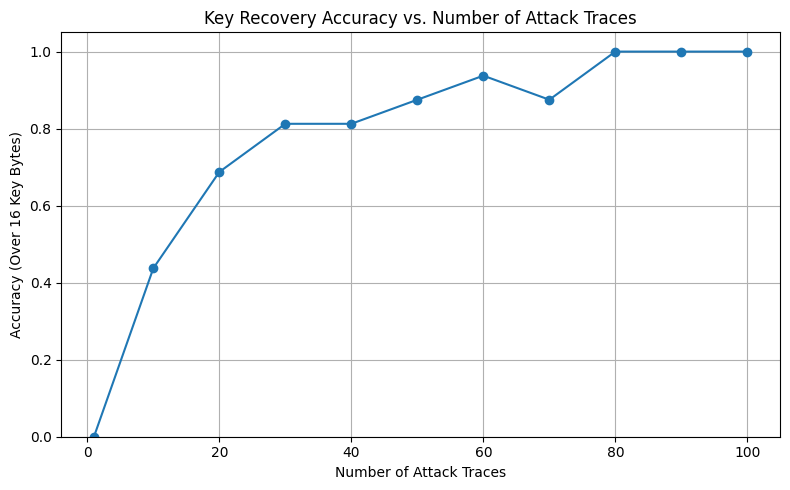

In [83]:
plt.figure(figsize=(8, 5))
plt.plot(attack_trace_counts, accuracies, marker='o')
plt.title("Key Recovery Accuracy vs. Number of Attack Traces")
plt.xlabel("Number of Attack Traces")
plt.ylabel("Accuracy (Over 16 Key Bytes)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_vs_attack_trace_count.png", dpi=300)
plt.show()


This graph shows the probability of successfully recovering key byte 3 as a function of the number of template traces. For each value of N, the attack was repeated 20 times using randomly sampled template subsets. The success rate increases with N, demonstrating the importance of sufficient template data.



In [91]:
BYTE_COUNT = 16
TEMPLATE_TRACE_COUNT = 100
REPEATS = 20
attack_trace_counts = [1, 20, 40, 60, 80, 100]
success_rates = []

real_key = "This is Correct!".encode("ascii")

# Prepare template once
template_traces_subset = template_traces[:TEMPLATE_TRACE_COUNT]
template_plaintext_subset = template_plaintext[:TEMPLATE_TRACE_COUNT]
template_keys_subset = template_keys[:TEMPLATE_TRACE_COUNT]

success_rates = []

for N in attack_trace_counts:
    print(f"Testing with {N} attack traces...")
    full_successes = 0

    for run in range(REPEATS):
        guessed_key = bytearray(16)

        # TEMPLATE PHASE
        traces_by_HW = [
            sort_by_HW(byte_i, template_plaintext_subset, template_keys_subset, template_traces_subset)
            for byte_i in range(BYTE_COUNT)
        ]
        SNRs = [compute_snr_from_hw_groups(hw_groups) for hw_groups in traces_by_HW]
        POIs_list = [find_POIs(snr) for snr in SNRs]
        traces_at_POIs_list = [filter_POIs(traces_by_HW[i], POIs_list[i]) for i in range(BYTE_COUNT)]

        SBOX_PDFs_list = []
        for i in range(BYTE_COUNT):
            SBOX_PDFs = []
            for hw in range(9):
                try:
                    traces_i = traces_at_POIs_list[i][hw]
                    traces_array = np.array(traces_i)
                    if traces_array.shape[0] == 0 or np.isnan(traces_array).any() or np.isinf(traces_array).any():
                        raise ValueError("Invalid class")
                    pdf = calculate_PDF(traces_i)
                except:
                    pdf = None
                SBOX_PDFs.append(pdf)
            SBOX_PDFs_list.append(SBOX_PDFs)

        # ATTACK PHASE
        attack_traces_subset = secret_key_traces[:N]
        attack_plaintext_subset = secret_plaintext[:N]

        for byte_i in range(BYTE_COUNT):
            POIs = POIs_list[byte_i]
            filtered_attack = [[trace[p] for p in POIs] for trace in attack_traces_subset]
            probs = []

            for guess in range(256):
                test_key = bytearray(guessed_key)
                test_key[byte_i] = guess
                log_prob = 0
                for pt_index, pt in enumerate(attack_plaintext_subset):
                    hw_class = bin(SBOX[test_key[byte_i] ^ pt[byte_i]]).count("1")
                    if SBOX_PDFs_list[byte_i][hw_class] is None:
                        continue
                    log_prob += SBOX_PDFs_list[byte_i][hw_class].logpdf(np.array(filtered_attack[pt_index]))
                probs.append(log_prob)

            guessed_key[byte_i] = int(np.argmax(probs))

        if guessed_key == real_key:
            full_successes += 1

    rate = full_successes / REPEATS
    print(f"Success rate (full key correct) for {N} traces: {rate:.2%}")
    success_rates.append(rate)


Testing with 1 attack traces...
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10072\389987549.py:10: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(traces_by_POIs)


Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 8 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 0 in SNR computation: empty or invalid
Skipping HW class 8 in SNR comp

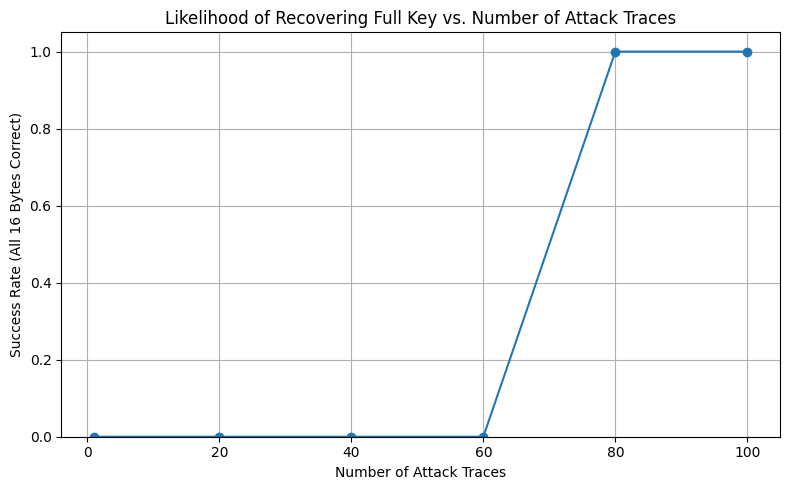

In [94]:
plt.figure(figsize=(8, 5))
plt.plot(attack_trace_counts, success_rates, marker='o')
plt.title("Likelihood of Recovering Full Key vs. Number of Attack Traces")
plt.xlabel("Number of Attack Traces")
plt.ylabel("Success Rate (All 16 Bytes Correct)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.savefig("likelihood_full_key_vs_attack_trace_count.png", dpi=300)
plt.show()



Average leakage at the top POI as a function of Hamming Weight class (for Byte 8). A clear monotonic trend confirms the presence of side-channel leakage that correlates with the Hamming Weight of intermediate values.

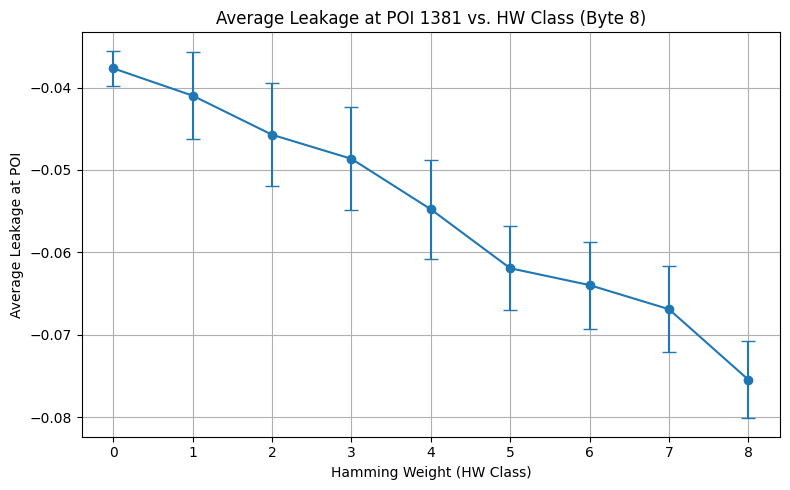

In [93]:
# Select byte index to analyze
BYTE_TO_ANALYZE = 8

# Use fixed template data
template_traces_subset = template_traces[:1000]
template_plaintext_subset = template_plaintext[:1000]
template_keys_subset = template_keys[:1000]

# Group by HW
traces_by_HW = sort_by_HW(BYTE_TO_ANALYZE, template_plaintext_subset, template_keys_subset, template_traces_subset)
SNR = compute_snr_from_hw_groups(traces_by_HW)
POIs = find_POIs(SNR)

# Choose one POI (e.g., the one with highest SNR)
main_POI = POIs[0]

# Compute average leakage at that POI for each HW class
avg_leakages = []
std_leakages = []

for hw in range(9):
    group = traces_by_HW[hw]
    if len(group) == 0:
        avg_leakages.append(np.nan)
        std_leakages.append(0)
        continue

    values = [trace[main_POI] for trace in group]
    avg_leakages.append(np.mean(values))
    std_leakages.append(np.std(values))

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(range(9), avg_leakages, yerr=std_leakages, fmt='o-', capsize=5)

plt.title(f"Average Leakage at POI {main_POI} vs. HW Class (Byte {BYTE_TO_ANALYZE})")
plt.xlabel("Hamming Weight (HW Class)")
plt.ylabel("Average Leakage at POI")
plt.grid(True)
plt.xticks(range(9))
plt.tight_layout()
plt.savefig(f"leakage_vs_HW_byte{BYTE_TO_ANALYZE}.png", dpi=300)
plt.show()



This figure compares the empirical leakage distribution at the highest-SNR POI for HW class 5 with the fitted Gaussian model. The close alignment validates the assumption that leakage within each HW class can be modeled as a Gaussian distribution — a core premise of the template attack.

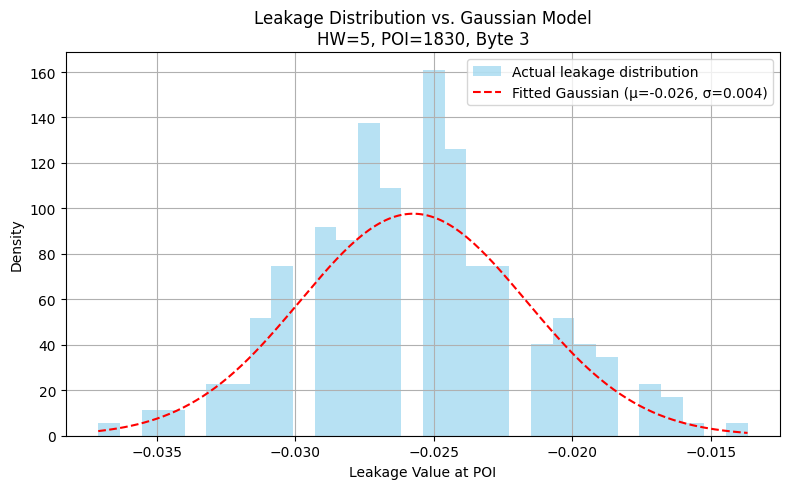

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Byte to analyze and template traces
BYTE_TO_ANALYZE = 3
TEMPLATE_TRACE_COUNT = 1000
HW_CLASS = 5  # choose one class (e.g., 5)

# Get the template data
template_traces_subset = template_traces[:TEMPLATE_TRACE_COUNT]
template_plaintext_subset = template_plaintext[:TEMPLATE_TRACE_COUNT]
template_keys_subset = template_keys[:TEMPLATE_TRACE_COUNT]

# Group traces by HW
traces_by_HW = sort_by_HW(BYTE_TO_ANALYZE, template_plaintext_subset, template_keys_subset, template_traces_subset)
SNR = compute_snr_from_hw_groups(traces_by_HW)
POIs = find_POIs(SNR)
best_POI = POIs[0]

# Get the leakage values at best POI for HW class
hw_traces = traces_by_HW[HW_CLASS]
leakage_values = [trace[best_POI] for trace in hw_traces]

# Fit a Gaussian
mean = np.mean(leakage_values)
std = np.std(leakage_values)
x = np.linspace(min(leakage_values), max(leakage_values), 200)
pdf = norm.pdf(x, mean, std)

# Plot
plt.figure(figsize=(8, 5))
plt.hist(leakage_values, bins=30, density=True, alpha=0.6, color='skyblue', label="Actual leakage distribution")
plt.plot(x, pdf, 'r--', label=f"Fitted Gaussian (μ={mean:.3f}, σ={std:.3f})")
plt.title(f"Leakage Distribution vs. Gaussian Model\nHW={HW_CLASS}, POI={best_POI}, Byte {BYTE_TO_ANALYZE}")
plt.xlabel("Leakage Value at POI")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"gmm_vs_leakage_hw{HW_CLASS}_poi{best_POI}.png", dpi=300)
plt.show()
